# Special assignment - Data analysis workflows

This notebook contains the special assignment for the [Data analysis workflows-course](https://aaltoscicomp.github.io/data-analysis-workflows-course/). The assignment consists of three problems. Each problem is worth 6 points so the maximum number of points is 18. To successfully complete the assignment one needs to get at least 9 points.  Solutions can be done with Python or R, but they need to be able to run with the course environment.

The answers and the datasets used by the anwers should be returned as notebook files stored as a zip-file and sent to scip -at- aalto.fi. They need to be in a form where running the whole kernel produces the answers.

# Problem 1 - Economic Freedom of the World analysis

The [Economic Freedom of the World index](https://www.fraserinstitute.org/economic-freedom/) is an annual survey that is widely used in the fields of economic and social science to indicate the economic freedom of different countries. Let's use the ([2020 dataset](https://www.fraserinstitute.org/sites/default/files/efw-2020-master-index-data-for-researchers.xlsx)) for the following tasks:

1. Augment the data by including the geographical region (e.g. Europe, Africa) for each country. You can use [this dataset](https://datahub.io/core/country-codes) to provide that data. (1 point)
2. Calculate yearly mean value of the `Economic Freedom Summary Index` for each region. Plot it. Example result plot show below. (1 point)
3. Calculate percentage histogram of ratings for each year and each region (what percent of countries had rating 1,2,3,...,9,10 for each year and each region). Plot the results for years 1970 and 2018 with each country represented as a different bar. Example result plot shown below. (2 points)
4. Calculate the progress that each country has made since the first time it has appeared in the index. That is, calculate the difference between current rating and first rating. Do note that some countries are younger than 1970. Plot these differences by country and by region with each region in its own plot. Example result plots are shown below. (2 points)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
# 1

country_codes = pd.read_csv('../data/country-codes_csv.csv')
country_codes = country_codes.loc[:,['ISO3166-1-Alpha-3','Region Name']]
country_codes.columns = ['ISO_Code','Region']

efsi_data = pd.read_csv('../data/efw-2020-master-index-data-for-researchers.csv', sep=';', skiprows=3, header=1)
efsi_data = efsi_data.iloc[:, 1:5]
efsi_data = efsi_data.merge(country_codes,on='ISO_Code').dropna(axis=0)
efsi_data['Year'] = efsi_data['Year'].astype(int)

<AxesSubplot:xlabel='Year', ylabel='Economic Freedom Summary Index'>

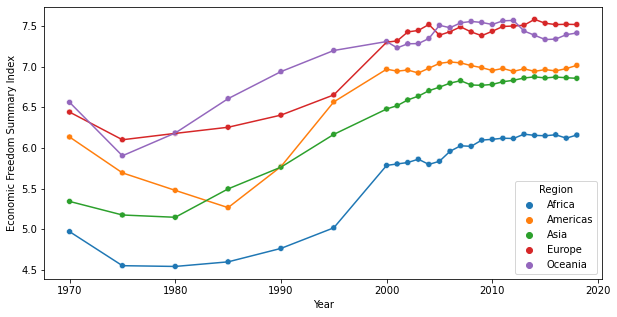

In [3]:
# 2

efsi_mean_by_region = efsi_data.groupby(['Year','Region']).mean('Economic Freedom Summary Index')

fig, ax = plt.subplots(figsize=(10,5))
sb.lineplot(x='Year', y='Economic Freedom Summary Index', data=efsi_mean_by_region, hue='Region', legend=None)
sb.scatterplot(x='Year', y='Economic Freedom Summary Index', data=efsi_mean_by_region, hue='Region')

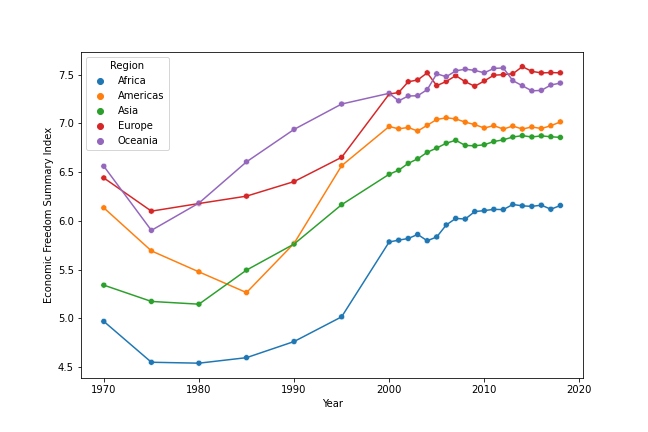

In [6]:
# Example image for task 2
from IPython.display import Image, display
Image(filename='efw-yearly-means.png')

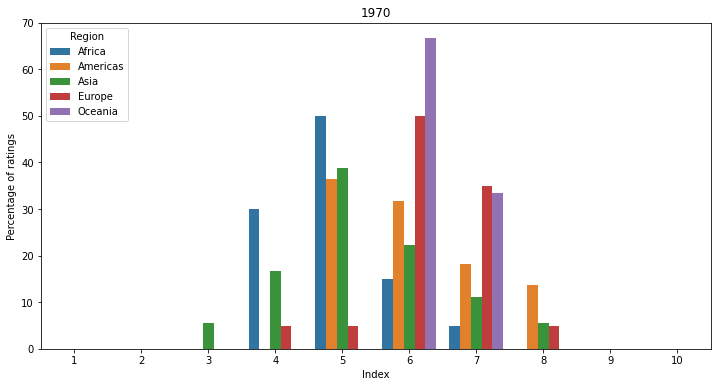

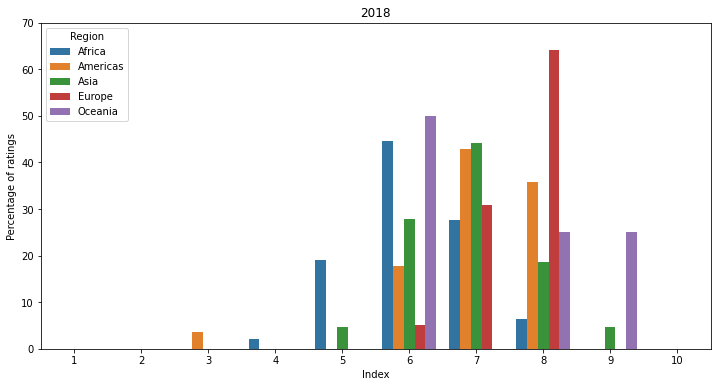

In [4]:
# 3 

efsi_data_grouped = efsi_data.groupby(['Year','Region'])

regions = np.sort(efsi_data['Region'].dropna().unique())

def get_year(year):
    results = pd.DataFrame()
    for region in regions:
        info = efsi_data_grouped.get_group((year, region)).copy()
        info['Index'] = np.round(info['Economic Freedom Summary Index']).astype(int)
        region_result = (info['Index'].value_counts(normalize=True, ascending=True)*100).reindex(range(1,11)).rename_axis('Index').reset_index(name='Percentage of ratings')
        region_result['Region'] = region
        results = results.append(region_result)
    fig, ax = plt.subplots(figsize=(12,6))
    sb.barplot(x='Index', y='Percentage of ratings', data=results, hue='Region')
    ax.set(ylim=(0,70))
    plt.title(year)
    plt.legend(title='Region', loc='upper left')
    plt.show()

result1970 = get_year(1970)
result2018 = get_year(2018)


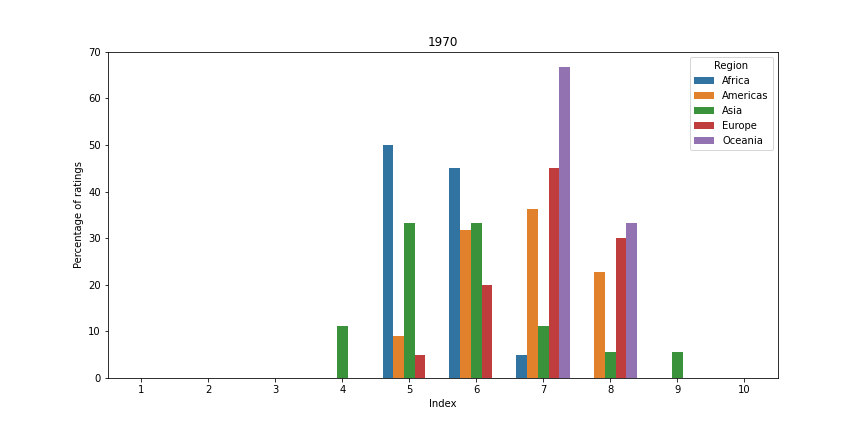

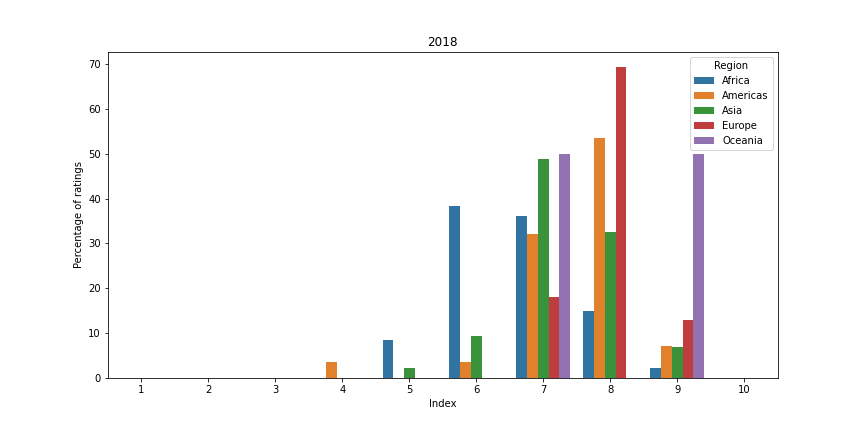

In [8]:
# Example image for task 3
for year in (1970, 2018):
    display(Image(filename='efw-percentage-%d.png' % year))

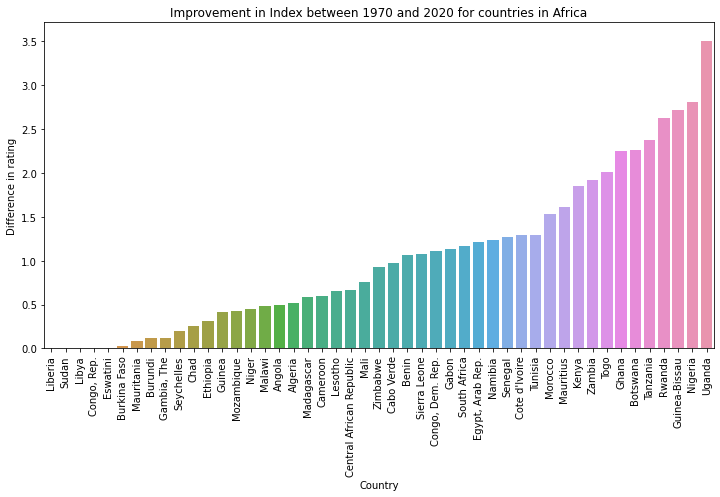

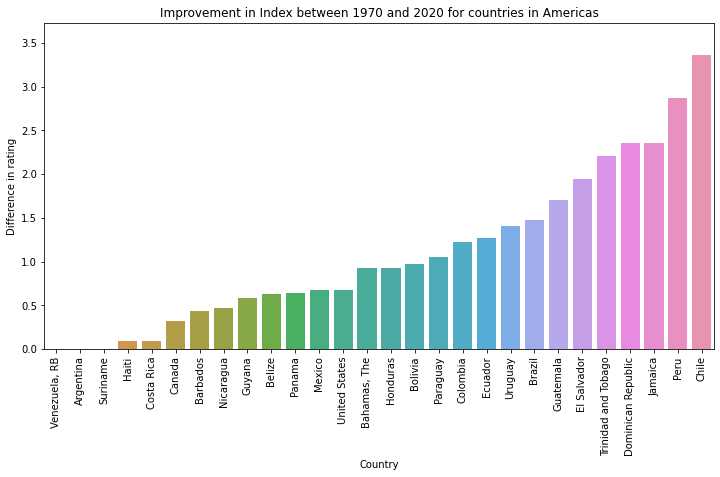

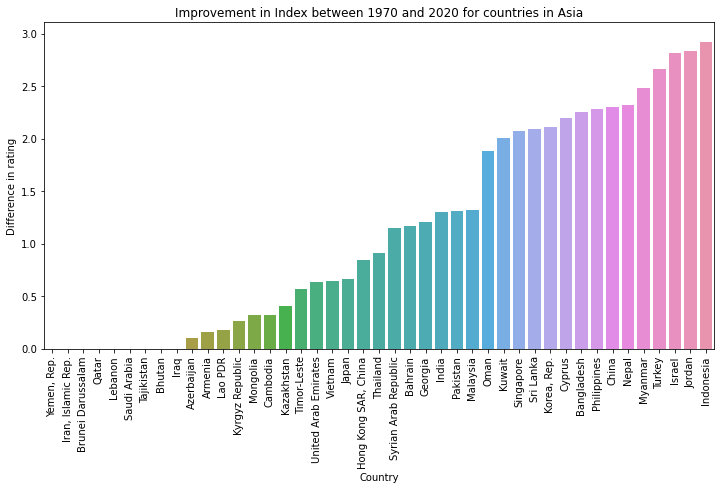

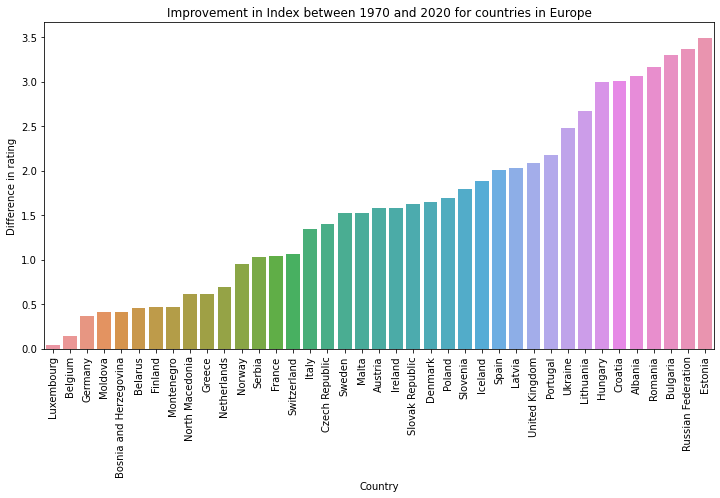

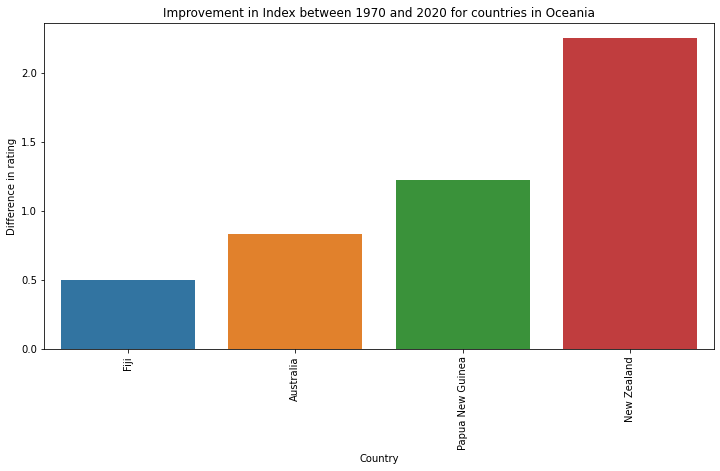

In [5]:
# 4

# Calculate the progress that each country has made since the first time it has appeared in the index. That is, calculate the difference between current rating 
# and first rating. Do note that some countries are younger than 1970. Plot these differences by country and by region with each region in its own plot. 
# Example result plots are shown below. (2 points)

efsi_data_by_country = efsi_data.groupby(['Countries','Region'])

from decimal import *

def get_diff(country):
    info = efsi_data.loc[efsi_data['Countries'] == country]
    min_year = info['Year'].min()
    min_efsi = info['Economic Freedom Summary Index'].loc[info['Year'] == min_year].item()
    max_year = info['Year'].max()
    max_efsi = info['Economic Freedom Summary Index'].loc[info['Year'] == max_year].item()
    result = max_efsi - min_efsi
    return result

def plot_region(region):
    results = pd.DataFrame(columns=['Country', 'Difference in rating'])
    table = efsi_data[efsi_data['Region'] == region] 
    countries = table['Countries'].unique()
    for country in countries:
        row = {'Country': country, 'Difference in rating': get_diff(country)}
        results = results.append(row, ignore_index=True)
    results = results.sort_values(by=['Difference in rating'])
    fig, ax = plt.subplots(figsize=(12,6))
    plot = sb.barplot(x='Country', y='Difference in rating', data=results)
    plot.set_xticklabels(results['Country'], rotation=90)
    plt.ylim(bottom=0)
    plt.title('Improvement in Index between 1970 and 2020 for countries in ' + region)
    plt.show()
    
for region in regions:
    plot_region(region)


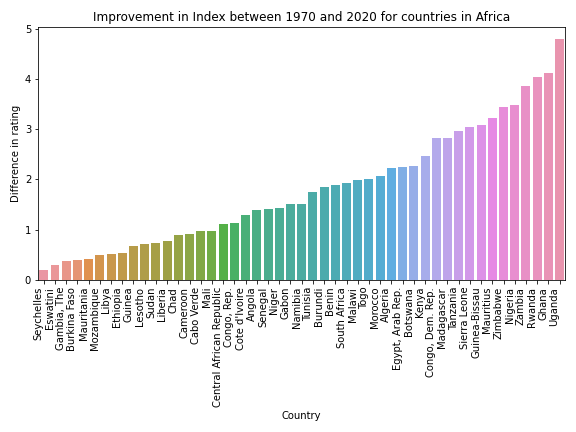

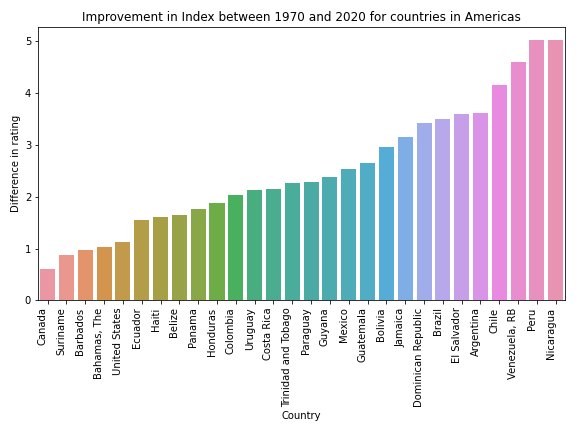

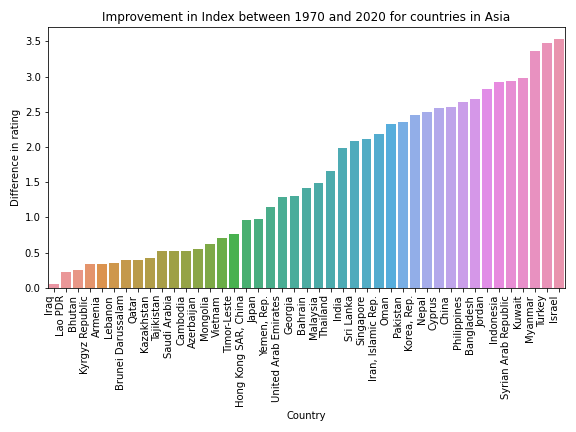

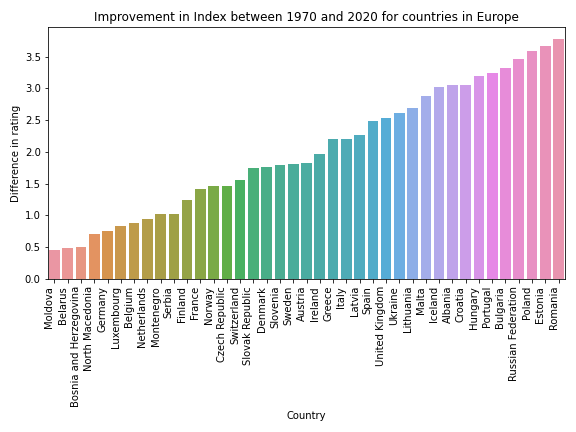

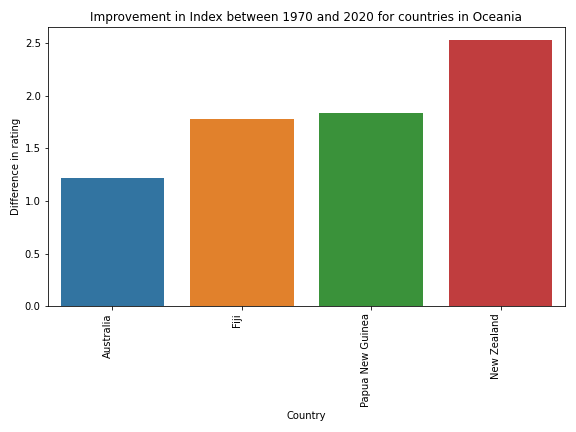

In [10]:
# Example image for task 4
for region in ('Africa',
               'Americas',
               'Asia',
               'Europe',
               'Oceania'):
    display(Image(filename='efw-difference-%s.png' % region))

# Problem 2 - Wine classification

Let's consider the [Wine quality machine learning dataset](http://archive.ics.uci.edu/ml/datasets/Wine+Quality) that contains physical measurements of white and red wines and a measured quality by testers.
¶
Let's create a machine learning pipeline that learns to classify features from these datasets. You can use e.g. decision trees as described in the chapter 1 for the classification task, but you can also use other classification model if you're interested.

1. Combine the red and white wine datasets, but add a column that contains the wine species information (e.g. `Species`-column). Change the ratings from range of 1 to 10 to levels `Bad` (rating = 1-4), `Ok` (rating = 5-6) and `Good` (rating = 7-10). (1 point)
2. Train a classifier that can recognize the wine species. Do not use non-physical quantities (rating etc.) for the classification. What accuracy does your model achieve? (2 points)
3. Split the data among wine species. For each species, train a classifier that recognizes the wine quality. So train two classifiers that try to determine what qualities make red/white wine good. What accuracy do your models achieve? (2 points)
4. After training the classifiers in task 3 try to predict the quality of the other wine species. That is, use the classifier for red wine quality to predict the white wine quality. Do you think that some of the learning is transferrable? (1 point)

In [7]:
# 1

red_wines = pd.read_csv('../data/winequality-red.csv', sep=';')
red_wines['Species'] = 'Red'
white_wines = pd.read_csv('../data/winequality-white.csv', sep=';')
white_wines['Species'] = 'White'

wines = red_wines.append(white_wines)

bad_wines = (wines['quality'] >= 1) & (wines['quality'] <=4)
ok_wines = (wines['quality'] >= 5) & (wines['quality'] <=6)
good_wines = (wines['quality'] >= 7) & (wines['quality'] <=10)

wines.loc[bad_wines, 'quality'] = 'Bad'
wines.loc[ok_wines, 'quality'] = 'Ok'
wines.loc[good_wines, 'quality'] = 'Good'
wines['quality'] = wines['quality'].astype('category')

In [8]:
from numpy.random import RandomState
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, confusion_matrix

In [9]:
# 2

def split_dataset(data, train_fraction=0.8,random_state=None):
    train_split, test_split = train_test_split(data, train_size=train_fraction, random_state=random_state)
    return (train_split, test_split)

def decision_tree_classifier(train_split, random_state=None):
    tree = DecisionTreeClassifier(random_state=random_state)
    train_data = train_split.drop(['Species', 'quality'], axis=1)
    train_target = train_split['Species']
    fitted_tree = tree.fit(train_data, train_target)
    print(export_text(fitted_tree, feature_names=list(train_data.columns)))
    return(fitted_tree)

def prediction_evaluation(test_split, model):
    test_data = test_split.drop(['Species', 'quality'], axis=1)
    test_target = test_split['Species']
    result_data = test_split.copy()
    result_data['PredictedValue'] = model.predict(test_data)
    result_data['Prediction'] = result_data.apply(lambda x: x['Species'] if x['Species'] == x['PredictedValue'] else 'Classification failure', axis=1)
    print('Confusion matrix:\n', confusion_matrix(result_data['PredictedValue'], result_data['Species']))
    print('Accuracy: ', accuracy_score(result_data['PredictedValue'], result_data['Species']))
    return result_data

train_wines, test_wines = split_dataset(wines)
fitted_tree_wines = decision_tree_classifier(train_wines)
prediction_wines = prediction_evaluation(test_wines, fitted_tree_wines)

# Model's accuracy is 0.9876923076923076

|--- chlorides <= 0.06
|   |--- total sulfur dioxide <= 50.50
|   |   |--- chlorides <= 0.04
|   |   |   |--- density <= 0.99
|   |   |   |   |--- pH <= 3.38
|   |   |   |   |   |--- class: White
|   |   |   |   |--- pH >  3.38
|   |   |   |   |   |--- class: Red
|   |   |   |--- density >  0.99
|   |   |   |   |--- class: Red
|   |   |--- chlorides >  0.04
|   |   |   |--- sulphates <= 0.42
|   |   |   |   |--- chlorides <= 0.05
|   |   |   |   |   |--- class: White
|   |   |   |   |--- chlorides >  0.05
|   |   |   |   |   |--- class: Red
|   |   |   |--- sulphates >  0.42
|   |   |   |   |--- density <= 0.99
|   |   |   |   |   |--- citric acid <= 0.29
|   |   |   |   |   |   |--- class: Red
|   |   |   |   |   |--- citric acid >  0.29
|   |   |   |   |   |   |--- class: White
|   |   |   |   |--- density >  0.99
|   |   |   |   |   |--- class: Red
|   |--- total sulfur dioxide >  50.50
|   |   |--- volatile acidity <= 0.82
|   |   |   |--- pH <= 3.83
|   |   |   |   |--- sulphates 

In [10]:
# 3

red_wines = wines[wines['Species'] == 'Red']
white_wines = wines[wines['Species'] == 'White']
print(red_wines)
print(white_wines)

def decision_tree_classifier_quality(train_split, random_state=None):
    tree = DecisionTreeClassifier(random_state=random_state)
    train_data = train_split.drop(['Species', 'quality'], axis=1)
    train_target = train_split['quality']
    fitted_tree = tree.fit(train_data, train_target)
    print(export_text(fitted_tree, feature_names=list(train_data.columns)))
    return(fitted_tree)

def prediction_evaluation_quality(test_split, model):
    test_data = test_split.drop(['Species', 'quality'], axis=1)
    test_target = test_split['quality']
    result_data = test_split.copy()
    result_data['PredictedValue'] = model.predict(test_data)
    result_data['Prediction'] = result_data.apply(lambda x: x['Species'] if x['Species'] == x['PredictedValue'] else 'Classification failure', axis=1)
    print('Confusion matrix:\n', confusion_matrix(result_data['PredictedValue'], result_data['quality']))
    print('Accuracy: ', accuracy_score(result_data['PredictedValue'], result_data['quality']))
    return result_data

train_wines_red, test_wines_red = split_dataset(red_wines)
fitted_tree_wines_red = decision_tree_classifier_quality(train_wines_red)
prediction_wines_red = prediction_evaluation_quality(test_wines_red, fitted_tree_wines_red)

# Model accuracy for red wines: 0.828125

train_wines_white, test_wines_white = split_dataset(white_wines)
fitted_tree_wines_white = decision_tree_classifier_quality(train_wines_white)
prediction_wines_white = prediction_evaluation_quality(test_wines_white, fitted_tree_wines_white)

# Model accuracy for white wines: 0.7755102040816326

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free sulfur dioxide  

# Problem 3 - Daily rhythm analysis

In the file [bash_prompt_counts](https://raw.githubusercontent.com/AaltoSciComp/data-analysis-workflows-course/master/special-assignment/bash_prompt_count), you find a list of times (unixtime) containing all of the times a person has used a `bash` prompt.  Study this data and make some visualizations based on it.

1. Read the data and find the correct time zones.  Hint: the first timestamp is 2007-08-15 20:34 in the local time.  Verify you got the conversion correct. (1 point)
2. Create new columns for `hour` and `yearmonth` (=`YYYY-MM`). Calculate the number of bash commmands issued for each `yearmonth` and `hour`. (2 points)
4. Create a heatmap which shows hours of the day on the vertical axis and Year-Month on the horizontal axis.  This should show how the time-of-day of the person's activity changes as years go by. Example result plot shown below. (2 points)
5. Give an evaluation of the data.  Is the person who created this normal?  The timezone changed sometime during the data.  Can you find it?  (1 point)

In [ ]:
# Example image for task 3
from IPython.display import Image, display
Image(filename='bash-heatmap.png')